# **Exercise 4: Non-Linear Advection-Diffusion Equation**

In [52]:
import numpy as np
import matplotlib.pyplot as plt

## Task 2: compute solution and order of convergence

In [53]:
# Exact solution
def exact_solution(x, t, eps):
    return -np.tanh((x + 0.5 - t)/(2*eps)) + 1.0

def g_L(t, eps):
    return exact_solution(-1.0, t, eps)

def g_R(t, eps):
    return exact_solution(+1.0, t, eps)

# Updates the solution at interior points for a time step
def step(u, dt, h, eps):
    u_new = np.copy(u)
    
    # Interior points
    for i in range(1, len(u)-1):
        # Advection term - upwind scheme
        if u[i] >= 0:  # Flow is from left to right
            flux_adv = u[i] * (u[i] - u[i-1])
        else:  # Flow is from right to left
            flux_adv = u[i] * (u[i+1] - u[i])
        
        # Diffusion term - central difference
        flux_diff = (u[i+1] - 2*u[i] + u[i-1])
        
        # Update solution using forward Euler
        u_new[i] = u[i] - dt/h * flux_adv + eps*dt/h**2 * flux_diff
    
    return u_new

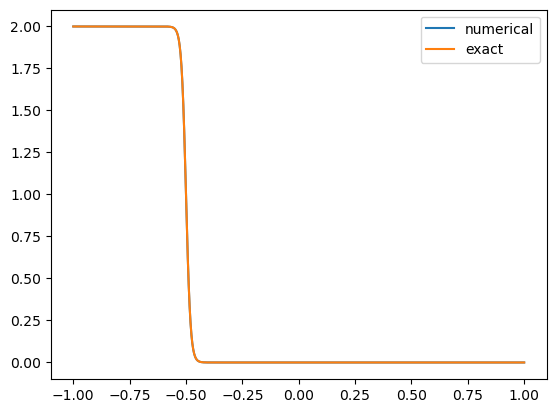

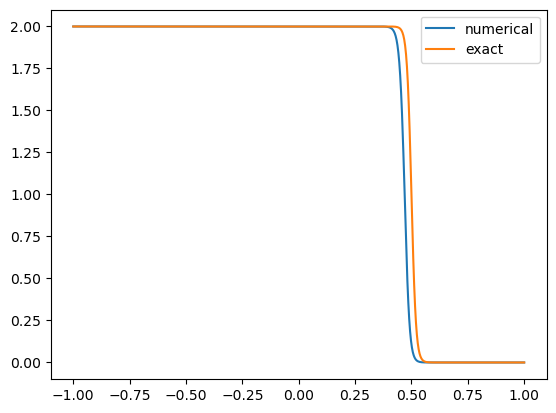

0.22892422786401972


In [62]:
# Domain
a = -1
b = 1

# Parameters
eps = 0.01
Cr_adv = 0.8  # safety factor for advection
Cr_diff = 0.5  # safety factor for diffusion

# Spatial mesh
N = 999
h = (b-a)/(N+1)
xi = np.arange(a,b+h,h)

# Temporal mesh
t_in, t_final = 0, 1

# Initial condition
u = exact_solution(xi, t_in, eps)

# Time steps
dt_adv = Cr_adv*h/np.max(np.abs(u))
dt_diff = Cr_diff*h**2/(2*eps)
dt = min(dt_adv, dt_diff)

# Save solution at each time step
u_sol = []
u_sol.append(u)

# Save times array as well
times = []

# Time iteration
# We can't do a for loop as we have to recalculate dt at each iteration
ti = 0.0
while ti < t_final:

    # Recalculate time step at each iteration for stability
    max_u = np.max(np.abs(u))
    dt_adv = Cr_adv*h/np.max(np.abs(u))
    dt_diff = Cr_diff*h**2/(2*eps)
    dt = min(dt_adv, dt_diff)

    # Make sure we don't overshoot the final time
    if ti + dt > t_final:
        dt = t_final - ti
    
    u = u.copy()

    # Apply boundary conditions
    u[0] = g_L(ti, eps)  # g_L(t)
    u[-1] = g_R(ti, eps)  # g_R(t)

    # Update solution
    u_new = step(u, dt, h, eps)
    u = u_new.copy()

    # Update time
    ti += dt

    # Save solution
    u_sol.append(u_new)
    times.append(ti)


# Plot exact solution and numerical solution at t=tfinal
plt.plot(xi,u_sol[0],label='numerical')
plt.plot(xi,exact_solution(xi,0,eps),label='exact')
plt.legend()
plt.show()

plt.plot(xi,u_sol[-1],label='numerical')
plt.plot(xi,exact_solution(xi,1,eps),label='exact')
plt.legend()
plt.show()

err = np.sqrt(np.sum((u - exact_solution(xi, t_final, eps))**2) * h)
print(err)

Convergence Test

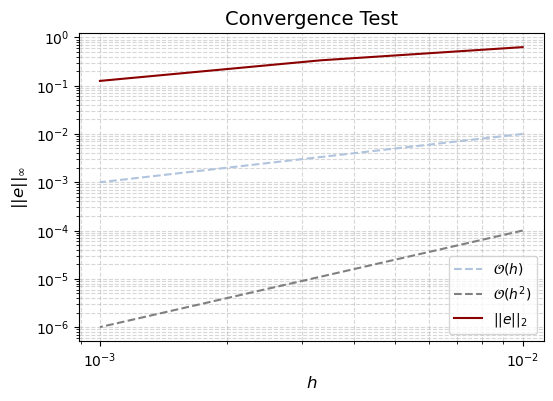

In [55]:
# Convergence study parameters
N_values = [199, 599, 1999]
h_values = [2/(N+1) for N in N_values]
eps = 0.01
t_final = 1.0
Cr_adv = 0.2
Cr_diff = 0.2

hs = []
errors = []

for N in N_values:
    # Grid
    a, b = -1, 1
    h = (b - a) / (N + 1)
    x = np.linspace(a, b, N + 2)
    u = exact_solution(x, 0, eps)
    t = 0.0

    # Time-step
    while t < t_final:
        max_u = np.max(np.abs(u))
        dt_adv = Cr_adv * h / max(max_u, 1e-10)
        dt_diff = Cr_diff * h**2 / (2 * eps)
        dt = min(dt_adv, dt_diff)
        if t + dt > t_final:
            dt = t_final - t

        # Apply BCs
        u[0] = g_L(t, eps)
        u[-1] = g_R(t, eps)

        # Advance one time step
        u = step(u, dt, h, eps)
        t += dt

    u[0] = g_L(t_final, eps)
    u[-1] = g_R(t_final, eps)

    # Compute L2 error
    u_ex = exact_solution(x, t_final, eps)
    err = np.sqrt(np.sum((u - u_ex)**2) * h)
    hs.append(h)
    errors.append(err)

# # Convergence rate computation
# rates = [np.log2(errors[i-1]/errors[i]) for i in range(1, len(errors))]

# # Print table
# print(f"{'N':>6} {'h':>10} {'L2 Error':>15} {'Rate':>10}")
# for i, N in enumerate(N_values):
#     h = hs[i]
#     e = errors[i]
#     r = rates[i-1] if i > 0 else None
#     print(f"{N:6d} {h:10.4f} {e:15.6e} {r:10.4f}" if r else f"{N:6d} {h:10.4f} {e:15.6e}")

# Plotting h vs errors in log-log scale to visualize the convergence rate
plt.style.use('default')
plt.figure(figsize=(6, 4))
plt.loglog(h_values, [h**1 for h in h_values], linestyle='--', label=r'$\mathcal{O}(h)$',color='lightsteelblue')
plt.loglog(h_values, [h**2 for h in h_values], linestyle='--', label=r'$\mathcal{O}(h^2)$',color='grey')
plt.loglog(h_values, errors, linestyle='-', label=r'$||e||_{{2}}$',color='darkred')

# Labels and legend
plt.xlabel(r'$h$',fontsize=12)
plt.ylabel(r'$||e||_{\infty}$',fontsize=12)
plt.title('Convergence Test',fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="--",alpha=.5)

     N          h        L∞ Error       Rate
   199     0.0100    1.988734e+00
   799     0.0025    1.425351e+00     0.2403
  1999     0.0010    7.351256e-01     0.7226
  2599     0.0008    5.839115e-01     0.8778


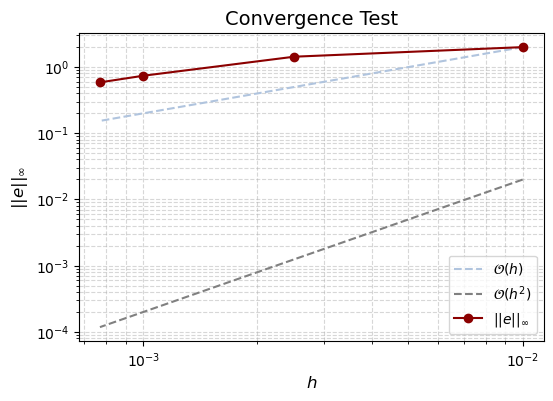

In [66]:
# Convergence study parameters
N_values = [199, 799, 1999, 2599]
h_values = [2/(N+1) for N in N_values]
eps = 0.01
t_final = 1.0
Cr_adv = 0.5 
Cr_diff = 0.5

hs = []
errors = []

for N in N_values:
    # Grid
    a, b = -1, 1
    h = (b - a) / (N + 1)
    x = np.linspace(a, b, N + 2)
    u = exact_solution(x, 0, eps)
    t = 0.0

    # Time-step
    while t < t_final:
        max_u = np.max(np.abs(u))
        dt_adv = Cr_adv * h / max(max_u, 1e-10)
        dt_diff = Cr_diff * h**2 / (2 * eps)
        dt = min(dt_adv, dt_diff)
        if t + dt > t_final:
            dt = t_final - t

        # Apply BCs
        u[0] = g_L(t, eps)
        u[-1] = g_R(t, eps)

        # Advance one time step
        u = step(u, dt, h, eps)
        t += dt

    u[0] = g_L(t_final, eps)
    u[-1] = g_R(t_final, eps)

    # Compute infinity norm error (maximum absolute error)
    u_ex = exact_solution(x, t_final, eps)
    err = np.max(np.abs(u - u_ex))
    hs.append(h)
    errors.append(err)

# Convergence rate computation
rates = [np.log(errors[i-1]/errors[i])/np.log(hs[i-1]/hs[i]) for i in range(1, len(errors))]

# Print table
print(f"{'N':>6} {'h':>10} {'L∞ Error':>15} {'Rate':>10}")
for i, N in enumerate(N_values):
    h = hs[i]
    e = errors[i]
    r = rates[i-1] if i > 0 else None
    print(f"{N:6d} {h:10.4f} {e:15.6e} {r:10.4f}" if r else f"{N:6d} {h:10.4f} {e:15.6e}")

# Plotting h vs errors in log-log scale to visualize the convergence rate
plt.style.use('default')
plt.figure(figsize=(6, 4))

# Scale reference lines to match error magnitude
ref_factor = errors[0]/h_values[0]  # Scale to match the first error point

plt.loglog(h_values, ref_factor * np.array(h_values), linestyle='--', label=r'$\mathcal{O}(h)$', color='lightsteelblue')
plt.loglog(h_values, ref_factor * np.array(h_values)**2, linestyle='--', label=r'$\mathcal{O}(h^2)$', color='grey')
plt.loglog(h_values, errors, linestyle='-', marker='o', label=r'$||e||_{\infty}$', color='darkred')

# Labels and legend
plt.xlabel(r'$h$', fontsize=12)
plt.ylabel(r'$||e||_{\infty}$', fontsize=12)
plt.title('Convergence Test', fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="--", alpha=.5)